In [ ]:
!pip install polygon-api-client pandas numpy scikit-learn matplotlib

In [2]:
import os
import pandas as pd
from polygon import RESTClient
import numpy as np

# Set up your Polygon.io API key
API_KEY = "92KDB5xSLSQh1SlpLcWvLIEZSTCqcBNU"
client = RESTClient(API_KEY)

expiration_date = "2024-10-18"
strike_price = 195
ticker = "COIN"
contract_type  = "call"

option_snapshots = client.list_snapshot_options_chain(
    ticker,
    params={
        "expiration_date": expiration_date,
        "strike_price": strike_price,
        "contract_type": contract_type
    }
)

for option in option_snapshots:
    print(option)

# Delta

In [62]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression

def calculate_custom_delta(underlying_bars, option_bars):
    """
    Calculate custom Delta using linear regression over rolling windows.

    :param underlying_bars: List of Agg objects for the underlying stock
    :param option_bars: List of Agg objects for the option contract
    :return: DataFrame with calculated Deltas and related statistics
    """
    # Convert bars to DataFrames with close prices
    underlying_df = pd.DataFrame([
        {
            'timestamp': bar.timestamp,
            'underlying_price': bar.close
        } for bar in underlying_bars
    ]).set_index('timestamp')

    option_df = pd.DataFrame([
        {
            'timestamp': bar.timestamp,
            'option_price': bar.close
        } for bar in option_bars
    ]).set_index('timestamp')

    # Merge DataFrames on timestamp
    merged_df = underlying_df.join(option_df, how='inner')

    # Calculate price changes
    merged_df['underlying_price_change'] = merged_df['underlying_price'].diff()
    merged_df['option_price_change'] = merged_df['option_price'].diff()

    # Drop initial NaN values
    merged_df = merged_df.dropna()

    # Rolling window size
    default_window_size = 20  # Original window size
    data_length = len(merged_df)

    # Adjust window size if data is smaller
    window_size = min(default_window_size, data_length)

    if window_size < 2:
        print("Not enough data points to perform rolling regression.")
        merged_df['delta'] = np.nan
        stats = {
            'mean_delta': np.nan,
            'std_delta': np.nan,
        }
        return merged_df, stats

# Initialize list to store delta values
    deltas = [np.nan]  # First value is NaN since we need at least 2 points

    data_length = len(merged_df)

    # Loop over data to calculate expanding regression
    for i in range(1, data_length):
        # Use all data up to the current point
        window_data = merged_df.iloc[:i + 1]

        # Reshape data for regression
        X = window_data['underlying_price_change'].values.reshape(-1, 1)
        y = window_data['option_price_change'].values

        # Check if underlying price changes are not all zeros
        if np.any(X != 0):
            # Fit linear regression
            reg = LinearRegression().fit(X, y)
            delta = reg.coef_[0]
        else:
            delta = np.nan

        deltas.append(delta)

    # Add delta values to DataFrame
    merged_df['delta'] = deltas

    # Calculate overall statistics
    stats = {
        'mean_delta': merged_df['delta'].mean(),
        'std_delta': merged_df['delta'].std(),
    }

    return merged_df, stats

In [43]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

def evaluate_delta_performance(delta_df):
    """
    Evaluate the performance of the calculated Delta in predicting option price changes.

    :param delta_df: DataFrame containing 'delta', 'underlying_price_change', and 'option_price_change' columns
    :return: Dictionary of error metrics and the updated DataFrame with predicted option price changes
    """
    # Ensure necessary columns are present
    required_columns = ['delta', 'underlying_price_change', 'option_price_change']
    for col in required_columns:
        if col not in delta_df.columns:
            raise ValueError(f"Column '{col}' is missing from delta_df.")

    # Drop rows with NaN values in the required columns
    delta_df_clean = delta_df.dropna(subset=required_columns)

    if delta_df_clean.empty:
        print("No data available after dropping NaNs.")
        return None, delta_df

    # Calculate predicted option price changes using Delta
    delta_df_clean['predicted_option_price_change'] = delta_df_clean['delta'] * delta_df_clean['underlying_price_change']

    # Calculate residuals (errors)
    delta_df_clean['residuals'] = delta_df_clean['option_price_change'] - delta_df_clean['predicted_option_price_change']

    # Compute error metrics
    mae = mean_absolute_error(delta_df_clean['option_price_change'], delta_df_clean['predicted_option_price_change'])
    mse = mean_squared_error(delta_df_clean['option_price_change'], delta_df_clean['predicted_option_price_change'])
    rmse = np.sqrt(mse)
    r2 = r2_score(delta_df_clean['option_price_change'], delta_df_clean['predicted_option_price_change'])

    metrics = {
        'Mean Absolute Error': mae,
        'Mean Squared Error': mse,
        'Root Mean Squared Error': rmse,
        'R-squared': r2
    }

    return metrics, delta_df_clean

In [ ]:
underlying_ticker = "COIN"
options_ticker = "O:COIN241018C00195000"

underlying_bars = client.get_aggs(ticker=underlying_ticker, multiplier=1, timespan="hour", from_="2024-10-07", to="2024-10-15", adjusted=True, limit=5000)
option_bars = client.get_aggs(ticker=options_ticker, multiplier=1, timespan="hour", from_="2024-10-07", to="2024-10-15", adjusted=True, limit=5000)

delta_df, delta_stats = calculate_custom_delta(underlying_bars, option_bars)
print(delta_df[['underlying_price', 'option_price', 'delta']].tail())
print(delta_stats)

# Assuming you have delta_df from the calculate_custom_delta function
metrics, delta_df_with_predictions = evaluate_delta_performance(delta_df)

# Print error metrics
print("Error Metrics:")
for key, value in metrics.items():
    print(f"{key}: {value}")

# Display the DataFrame with actual and predicted changes
print(delta_df_with_predictions[['option_price_change', 'predicted_option_price_change', 'residuals']])


# Theta

In [65]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

def calculate_empirical_theta_with_tte(underlying_bars, option_bars, expiration_timestamp):
    """
    Calculate Theta as the percentage decrease in the option's value over one hour due to time decay,
    using regression analysis while including time to expiration.
    
    :param underlying_bars: List of Agg objects for the underlying stock.
    :param option_bars: List of Agg objects for the option contract.
    :param expiration_timestamp: Expiration timestamp of the option (in milliseconds since epoch).
    :return: Dictionary containing Theta estimate and model performance metrics, and the merged DataFrame.
    """
    # Step 1: Data Preparation

    # Convert bars to DataFrames
    underlying_df = pd.DataFrame([
        {
            'timestamp': pd.to_datetime(bar.timestamp, unit='ms'),
            'underlying_price': bar.close
        } for bar in underlying_bars
    ]).set_index('timestamp')

    option_df = pd.DataFrame([
        {
            'timestamp': pd.to_datetime(bar.timestamp, unit='ms'),
            'option_price': bar.close
        } for bar in option_bars
    ]).set_index('timestamp')

    # Merge DataFrames on timestamp
    merged_df = underlying_df.join(option_df, how='inner')

    # Ensure the DataFrame is sorted by timestamp
    merged_df = merged_df.sort_index()

    # Calculate time to expiration in hours
    expiration_datetime = pd.to_datetime(expiration_timestamp, unit='ms')
    merged_df['time_to_expiration'] = (expiration_datetime - merged_df.index).total_seconds() / 3600

    # Calculate time difference between data points in hours
    merged_df['delta_time'] = -merged_df['time_to_expiration'].diff()

    # Calculate price changes
    merged_df['delta_underlying_price'] = merged_df['underlying_price'].diff()
    merged_df['delta_option_price'] = merged_df['option_price'].diff()

    # Drop rows with NaN values resulting from shifts
    merged_df = merged_df.dropna()

    # Prepare independent variables (X) and dependent variable (y)
    X = pd.DataFrame({
        'delta_underlying_price': merged_df['delta_underlying_price'],
        'delta_time': merged_df['delta_time'],
        # Include other variables if available
    })

    y = merged_df['delta_option_price']

    # Step 2: Fit the Regression Model
    model = LinearRegression()
    model.fit(X, y)

    # Extract coefficients
    coefficients = dict(zip(X.columns, model.coef_))
    intercept = model.intercept_

    # Extract Theta (coefficient of delta_time)
    theta_coefficient = coefficients.get('delta_time', None)

    # Step 3: Calculate Theta Percentage
    average_option_price = merged_df['option_price'].mean()
    theta_percentage = (theta_coefficient / average_option_price) * 100

    # Step 4: Validate the Model
    y_pred = model.predict(X)
    mae = mean_absolute_error(y, y_pred)
    mse = mean_squared_error(y, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y, y_pred)

    # Prepare results
    results = {
        'theta_coefficient_per_hour': theta_coefficient,
        'theta_percentage_per_hour': theta_percentage,
        'model_coefficients': coefficients,
        'intercept': intercept,
        'mean_absolute_error': mae,
        'root_mean_squared_error': rmse,
        'r_squared': r2
    }

    return results, merged_df

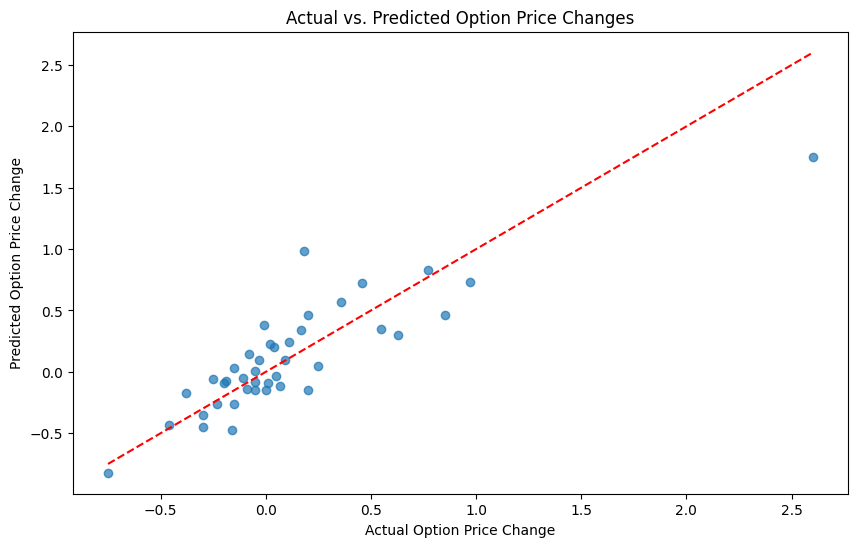

In [71]:
# After calling the function
results, merged_df = calculate_empirical_theta_with_tte(underlying_bars, option_bars, expiration_timestamp)

# Prepare independent variables (X) and dependent variable (y)
X = pd.DataFrame({
    'delta_underlying_price': merged_df['delta_underlying_price'],
    'delta_time': merged_df['delta_time'],
})

y = merged_df['delta_option_price']

# Reconstruct y_pred using the model coefficients
y_pred = results['intercept'] + \
         results['model_coefficients']['delta_underlying_price'] * X['delta_underlying_price'] + \
         results['model_coefficients']['delta_time'] * X['delta_time']

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.scatter(y, y_pred, alpha=0.7)
plt.xlabel('Actual Option Price Change')
plt.ylabel('Predicted Option Price Change')
plt.title('Actual vs. Predicted Option Price Changes')
plt.plot([y.min(), y.max()], [y.min(), y.max()], color='red', linestyle='--')  # Reference line y = x
plt.show()